In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy import stats
from scipy import integrate
from celluloid import Camera
from bayes_opt import BayesianOptimization
import json
import seaborn as sns
from scipy import special
import Numerical_multiprocess
import pymongo

In [2]:
#Main variables

main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000


Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
v_max = 25.
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat


In [1]:
import importlib

importlib.reload(Numerical_multiprocess)

NameError: name 'Numerical_multiprocess' is not defined

In [6]:
connection = pymongo.MongoClient("mongodb://localhost:27017")
vc = connection.db.Expected_model
max_parameters = vc.find(projection = {"_id" : 0},limit=5).sort("target",pymongo.DESCENDING)
sols = Numerical_multiprocess.main_iteration(**max_parameters[0]["params"])

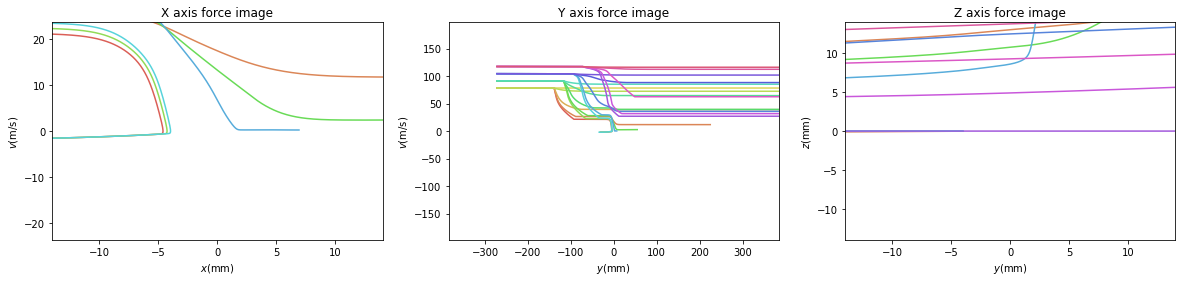

In [5]:
colors = sns.color_palette('hls',len(sols))

fig,ax = plt.subplots(1,3,figsize=(20,4))

ax[2].set_ylabel("$z (\mathrm{mm})$")
ax[2].set_xlabel('$y (\mathrm{mm})$')
# ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[2].set_xlim(-14,14)
ax[2].set_ylim(-14,14)
# ax[2].set_ylabel('$v (\mathrm{m/s})$')
# ax[2].set_ylim(-1*v_max*v0,1*v_max*v0)
ax[2].set_title('Z axis force image')


ax[0].set_xlabel('$x (\mathrm{mm})$')
ax[0].set_ylabel('$v (\mathrm{m/s})$')
# ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
# ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
ax[0].set_xlim(-14,14)
ax[0].set_ylim(-1*3*v0,3*v0)
ax[0].set_title('X axis force image')


ax[1].set_xlabel('$y (\mathrm{mm})$')
ax[1].set_ylabel('$v (\mathrm{m/s})$')
ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
ax[1].set_title('Y axis force image')

fig.subplots_adjust(left=0.12,right=0.9)

for sol,clr in zip(sols,colors):
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0,color=clr)
    ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0,color=clr)
    ax[2].plot(sol.r[1]*x0*1000,sol.r[2]*x0*1000,color=clr)

In [6]:
counter = 0
for sol in sols:
    if len(sol.t_events[0])==1:
        counter+=1
        print(sol.v[0][0]*np.sqrt(2),sol.v[2][0])

print(counter)

0


In [8]:
fig.savefig("D:/pr/QuantumInformation/Picture/numerical")

In [ ]:
#Define the zero magnetic field.

# def Bfield(R,t,MOTon):
#     if t<MOTon:
#         return np.zeros(3)
#     elif MOTon<=t:
#         return np.array([-0.5*mag_field_grad*R[0],1.*mag_field_grad*R[1],-0.5*mag_field_grad*R[2]])
    
magField = pylcp.quadrupoleMagneticField(mag_field_grad)
# magField = np.zeros(3,)

In [ ]:
from scipy.interpolate import RegularGridInterpolator

xs = np.linspace(-0.4,0.4,101)/x0
ys = np.linspace(-0.4,0.4,101)/x0
zs = np.linspace(-0.2,0.2,101)/x0

X,Y,Z = np.meshgrid(xs,ys,zs,sparse=1,indexing="ij")
B = np.load("B_3D_interp_0427.npy")

Bx = RegularGridInterpolator((xs,ys,zs),B[0])
By = RegularGridInterpolator((xs,ys,zs),B[1])
Bz = RegularGridInterpolator((xs,ys,zs),B[2])

def B_func(R:np.array):
    if abs(R[2])>0.2/x0 or abs(R[1])>0.4/x0 or abs(R[0])>0.4/x0:
        return np.zeros(3,)
    return np.array([Bx(R),By(R),Bz(R)]).reshape(-1)

In [ ]:
def Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff,s,d1,d2,d3,d4,pol1,pol2,pol3,pol4):
    det_side = det_1/Gamma
    det_side2 = det_2/Gamma
    Avg_X = np.average(E_X)
    init_pow = 0.5*2./(np.pi*(0.012)**2)/Isat
    
    def Gaussian_Beam_Intensity(R,waist):
        return np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)
    
    def Bessel_Intensity(n_order,beta):
        return special.jv(n_order,beta)**2
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0
        
    
    def pick_EOM(b):
        N_list = range(round(-b)-2,round(b)+2)
        order_list = list()
        # intensity_list = list()
        for n in N_list:
            temp = Bessel_Intensity(n,b)
            if temp>=0.01:
                order_list.append(n)
                # intensity_list.append(temp)
    
        # return order_list, intensity_list
        return order_list
    
    def laser_set(m,n):
        return pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+m*det_side+det_side2*n,
                                     's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(m,beta_1)*Bessel_Intensity(n,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+m*det_side-det_side2*n,
                                     's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(m,beta_1)*Bessel_Intensity(n,beta_2)}])
    
    
    white_order = pick_EOM(beta_2)
    
    laserBeams = pylcp.laserBeams()
    for m in {-1,0,1}:
        for n in white_order:
            laserBeams+=laser_set(m,n)
                                        

    def MOT_step(t):
        if laseroff<=t and t<laseroff+14:
            return -1*(t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2+1/2
        elif laseroff+14<=t:
            return 1
        else:
            return 0     
    
    def Gaussian_Beam_Axis(R,waist,ax):
        if ax==0:
            return np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)
        elif ax==1:
            return np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)
        elif ax==2:
            return np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)


    for ii, Eg_i in enumerate(E_X):
        if ii==0:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
        elif ii==1:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}]) 
        elif ii==2:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
        else:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])

    return laserBeams

In [ ]:
def slow_bayesian(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff):
    laserBeams = Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff,intensities,-2.5,0.22,-0.668,-0.4729,-1,-1,1,1)
    magField = lambda R,t : B_func(R)
    rateeq = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    
    v_longitudinal = np.linspace(14,21,8)
    v_trans = np.linspace(0,2,5)
    counter = 0
    
    def Capture_velocity_condition(t,y,threshold = 5.810):
        if y[-6]<threshold:
            val = -1.
        else:
            val = 1.
        return val
    def Lost_condition(t,y,threshold = 0.):
        if y[-6]<threshold:
            val = -1.
        else:
            val = 1.
        return val
    def for_transverse_condition(t,y,threshold = -0.020/x0):
        if y[-3]>threshold:
            val = -1.
        else:
            val = 1.
        return val
    
    for v0_l in v_longitudinal:
        for v0_t in v_trans:
            rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0_l/np.sqrt(2),v0_l/np.sqrt(2),v0_t]))
            rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

            rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,max_step=2e5,progress_bar = 0,method='LSODA')
            sol = rateeq.sol
            if abs(sol.r[0][-1])*1000*x0<10 and abs(sol.r[2][-1])*1000*x0<10 and abs(sol.v[0][-1])<5e-2 and abs(sol.v[2][-1])<5e-2:
                counter+=1
            else:
                continue
    return counter

In [ ]:
start = time.time()

print(slow_bayesian(17,120,10,1.2,1.5,138250,400015))

print(time.time()-start)

In [ ]:
pbounds = {'main_det':(10,20),'det_1':(70,170),'det_2':(5,30),'beta_1':(0,2),'beta_2':(0,30),'laseron':(138240,300000),'laseroff':(300001,600000)}

In [ ]:
optimizer = BayesianOptimization(
    f = main_iteration,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [ ]:
from bayes_opt.util import load_logs

# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["./logs_slowing_with_beta_0428.json"])

In [ ]:
optimizer.max

In [ ]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

In [ ]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_slowing_with_beta_0428.json')
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [ ]:
start = time.time()
optimizer.maximize(
    init_points=5,
    n_iter=10,)
print(time.time()-start)

In [ ]:
optimizer.max

In [ ]:
start = time.time()
optimizer.maximize(
    init_points=10,
    n_iter=50,)
print(time.time()-start)

In [ ]:
optimizer.max

In [ ]:
from Numerical_multiprocess import *

In [ ]:
sols = main_iteration(**optimizer.max["params"])